# Caso de estudio: segmentación de clientes para supermarket

La compañía desea conocer si existen patrones que permitan segmentar los clientes en función de el monto total que gastaron en los últimos 2 años.

#### Librerías:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


### Carga de datos

In [3]:
df = pd.read_csv("superstore_data.csv", sep=',')
df.head(5)

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


### Limpieza y transformación

Eliminación de outliers:

In [4]:
df = df.dropna(how='any')
df = df.reset_index(drop=True)

Estandarización de valores:

In [5]:
for i in range(0, df.shape[0]):
  status = df['Marital_Status'][i]
  if status in ('YOLO', 'Absurd'):
    df = df.drop(i)
  elif status == 'Alone':
    df['Marital_Status'][i] = 'Single'
df = df.reset_index(drop=True)
df.head(5)

<ipython-input-5-4f6df25daa19>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Marital_Status'][i] = 'Single'


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


Incorporación de columna:

In [6]:
df['MntTotal'] = df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntFruits'] + df['MntWines'] + df['MntGoldProds']

Selección de variables de interés para nuestro caso de estudio

In [7]:
df = df.drop(columns = ["Response", "Dt_Customer"])

Conversión de variables categóricas a numéricas

In [8]:
df.dtypes

Id                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Complain                 int64
MntTotal                 int64
dtype: object

In [9]:
LE = LabelEncoder()

print(df["Education"].unique())
df["Education"]=df[["Education"]].apply(LE.fit_transform)
print(df["Education"].unique())
print(df["Marital_Status"].unique())
df["Marital_Status"]=df[["Marital_Status"]].apply(LE.fit_transform)
print(df["Marital_Status"].unique())

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
[2 4 0 3 1]
['Divorced' 'Single' 'Married' 'Together' 'Widow']
[0 2 1 3 4]


### Estandarización con scaler

In [10]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df),columns= df.columns )
scaled_df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,MntTotal
0,-1.158451,0.099252,-0.34919,-1.627371,1.294687,-0.824288,-0.92886,-1.695245,-0.343759,1.952978,...,1.347180,3.942066,3.374764,-0.687143,-0.030344,0.455525,0.061428,-1.783020,-0.097901,0.967268
1,-1.720471,-0.652041,-0.34919,0.253373,0.192937,-0.824288,-0.92886,-1.695245,0.470971,-0.536160,...,-0.559456,-0.658359,-0.132186,-0.687143,1.064023,0.113495,0.368848,-0.132103,-0.097901,-0.049271
2,1.505375,-0.902472,-0.34919,-0.686999,0.597039,-0.824288,0.90892,-1.695245,-0.506705,-0.385303,...,-0.412792,-0.609677,-0.267813,-0.687143,-0.395133,-0.228536,-0.245991,-1.370290,-0.097901,-0.589877
3,-1.293951,-0.151179,-0.34919,1.193745,-0.784636,1.038148,0.90892,-1.695245,-0.874075,-0.661874,...,-0.687787,-0.658359,-0.849076,-0.687143,-1.124711,-0.912597,-1.168251,0.693355,-0.097901,-0.987869
4,-0.066744,1.685313,-0.34919,0.253373,-1.221460,1.038148,-0.92886,-1.695245,-0.885925,-0.259589,...,-0.486124,-0.658359,-0.190312,-0.167143,-0.395133,-0.570566,-1.168251,0.693355,-0.097901,-0.855205


### Reducción de dimensionalidad usando el método Principal Component Analysis (PCA)

En este caso utilizaremos 3 componentes para el algoritmo de PCA

In [11]:
# Estandarización de las variables y entrenamiento del modelo
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components = 3))
pca_pipe.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3))])

In [12]:
modelo_pca = pca_pipe.named_steps['pca']

print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

Porcentaje de varianza explicada por cada componente
[0.33223882 0.09585918 0.06462774]


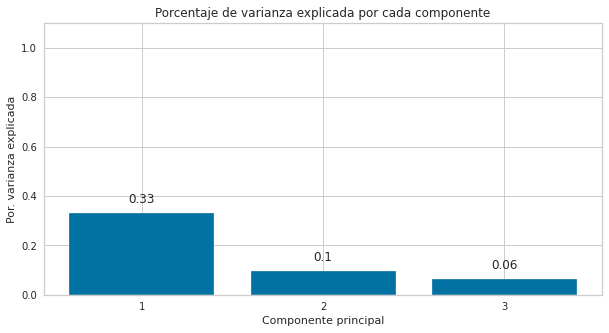

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(x= np.arange(modelo_pca.n_components_) + 1,height = modelo_pca.explained_variance_ratio_)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [14]:
PCA_m = pd.DataFrame(pca_pipe.transform(df), columns=(["PCA1","PCA2", "PCA3"]))
PCA_m.describe().T

,count,mean,std,min,25%,50%,75%,max
PCA1,2212.0,6.424437e-17,2.642001,-5.086216,-2.449727,-0.658382,2.307858,7.154225
PCA2,2212.0,-3.854662e-17,1.419138,-3.134608,-1.132417,-0.141017,1.020426,4.896869
PCA3,2212.0,-2.730386e-17,1.165287,-4.431738,-0.785382,0.003409,0.699730,5.436393


### Proyección de los datos en 3D en función de los componentes PCA

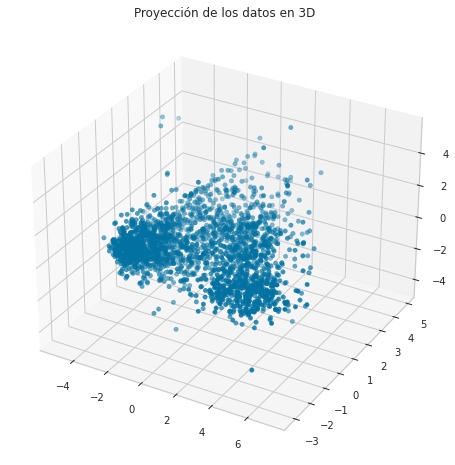

In [15]:
x = PCA_m["PCA1"]
y = PCA_m["PCA2"]
z = PCA_m["PCA3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, marker="o" )
ax.set_title("Proyección de los datos en 3D")
plt.show()

### Método del codo para establecer número óptimo de clústers

Método del codo para determinar el número de clusters a realizar:


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

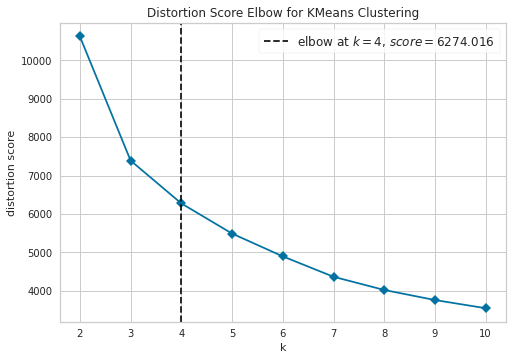

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
print('Método del codo para determinar el número de clusters a realizar:')
elbow = KElbowVisualizer(KMeans(), k=10, timings=False) 
elbow.fit(PCA_m)
elbow.show()

### Gráfico de clústers para n = 4

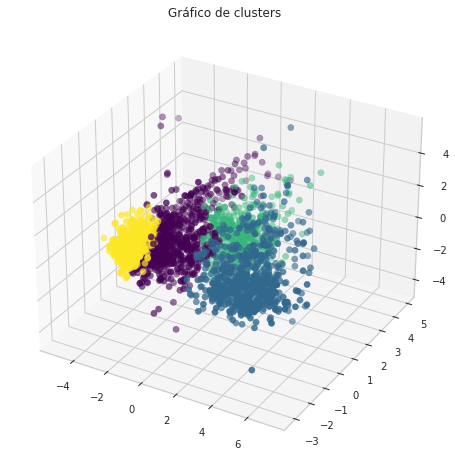

In [17]:
AC = AgglomerativeClustering(n_clusters=4)

yhat = AC.fit_predict(PCA_m) #predicción de clúster

PCA_m["Clusters"] = yhat
df["Clusters"] = yhat

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_m["Clusters"], marker='o', cmap="viridis")
ax.set_title("Gráfico de clusters")
plt.show()

### Análisis de variables agrupadas por clústers en función del gasto que realizan en el supermercado

Distribución del gasto según clúster al que pertenece el usuario

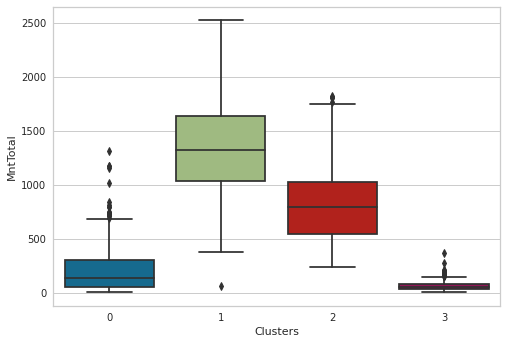

In [18]:
plt.figure()
pl=sns.boxplot(x=df["Clusters"], y=df["MntTotal"])
plt.show()

Distribución del monto total gastado según cantidad de hijos en el hogar

Distribución del monto total gastado según cantidad de hijos en el hogar


<Figure size 576x396 with 0 Axes>

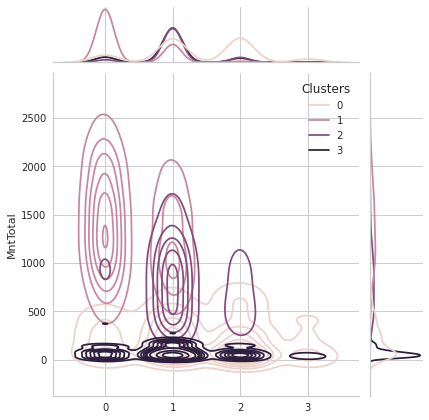

In [19]:
plt.figure()
print("Distribución del monto total gastado según cantidad de hijos en el hogar")
sns.jointplot(x=(df["Kidhome"]+df["Teenhome"]), y=df["MntTotal"], hue = df["Clusters"], kind="kde")
plt.show()

Distribución del monto total gastado según nivel educativo

Distribución del monto total gastado según nivel educativo
2n Cycle: 0, Basic: 1, Graduation: 2, Master: 3, PhD: 4


<Figure size 576x396 with 0 Axes>

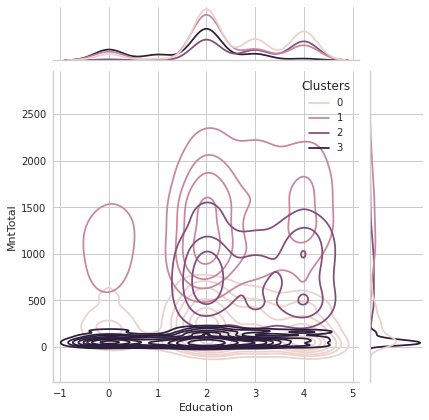

In [20]:
plt.figure()
print("Distribución del monto total gastado según nivel educativo")
print('2n Cycle: 0, Basic: 1, Graduation: 2, Master: 3, PhD: 4')
sns.jointplot(x=df["Education"], y=df["MntTotal"], hue = df["Clusters"], kind="kde")
plt.show()

Distribución del monto total gastado según estado civil

Distribución del monto total gastado según estado civil
Divorced: 0, Married: 1, Single: 2, Together:3, Widow: 4


<Figure size 576x396 with 0 Axes>

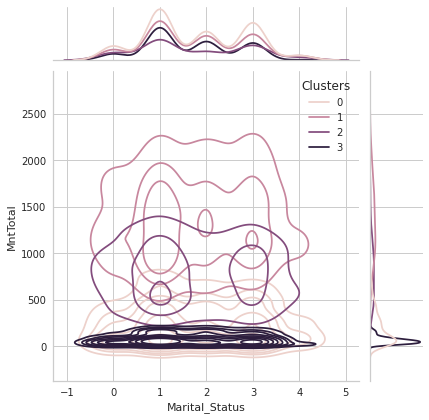

In [21]:
plt.figure()
print("Distribución del monto total gastado según estado civil")
print('Divorced: 0, Married: 1, Single: 2, Together:3, Widow: 4')
sns.jointplot(x=df["Marital_Status"], y=df["MntTotal"], hue = df["Clusters"], kind="kde")
plt.show()